# Capstone Project - The Battle of Neighborhoods
## Halal restaurants in New York  city 

### Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis.It is the largest city in the United States with a long history of international immigration. New York City was home to over 8.3 million people in 2019, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

Around 768,767 Muslims live in New York City as of 2016, making up about 8.96% of the city's total population of 8,583,000. Approximately 22.3% of America's Muslims live in New York City, and the Muslim community is rapidly growing on account of immigration, reproduction, and conversion.As a requirement of their religion, Muslims eat Halal food.

So in this project , I will list and visualize all major parts of New York City that has great Halal restaurants.

### Data

In this project I will use the following data :

* New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.  
Data source : https://cocl.us/new_york_dataset  
Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city. 
  

* Halal resturants in each neighborhood of new york city.  
Data source : Fousquare API  
Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only Halal resturants.
  

* GeoSpace data  
Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm  
Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

### Approach
* Collect the new york city data from https://cocl.us/new_york_dataset
* Using FourSquare API we will find all venues for each neighborhood.
* Filter out all venues that are Halal Resturants.
* Find rating , tips and like count for each Halal Resturants using FourSquare API.
* Using rating for each resturant , we will sort that data.
* Visualize the Ranking of neighborhoods using folium library(python)

### Questions that can be asked using the above mentioned datasets
* What is best location in New York City for Halal foods ?
* Which areas have potential Halal Restaurant Market ?
* Which all areas lack Halal Restaurants ?
* Which is the best place to stay if I prefer Halal foods ?

### Analysis
We will import the required libraries for python.

* pandas and numpy for handling data.
* request module for using FourSquare API.
* geopy to get co-ordinates of City of New York.
* folium to visualize the results on a map

In [1]:
! pip install geocoder


     |████████████████████████████████| 102kB 17.0MB/s ta 0:00:01


In [2]:
! pip install folium

     |████████████████████████████████| 102kB 7.9MB/s ta 0:00:011


In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [5]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'QM1LYJBLPJI0KK4PJWM1ACSJGRKCM3BEPSRFWB4KMVOF3G5Q' 
    CLIENT_SECRET = '0ZFBEHG1YQMPXKNYZK0RTN00FZXGLQGFSATUQTSM2QEHEC3Q'
    VERSION = '20200509' 
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [6]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'QM1LYJBLPJI0KK4PJWM1ACSJGRKCM3BEPSRFWB4KMVOF3G5Q' 
    CLIENT_SECRET = '0ZFBEHG1YQMPXKNYZK0RTN00FZXGLQGFSATUQTSM2QEHEC3Q'
    VERSION = '20200509'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data


We will call the above funtion to get the new york city data.

In [8]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

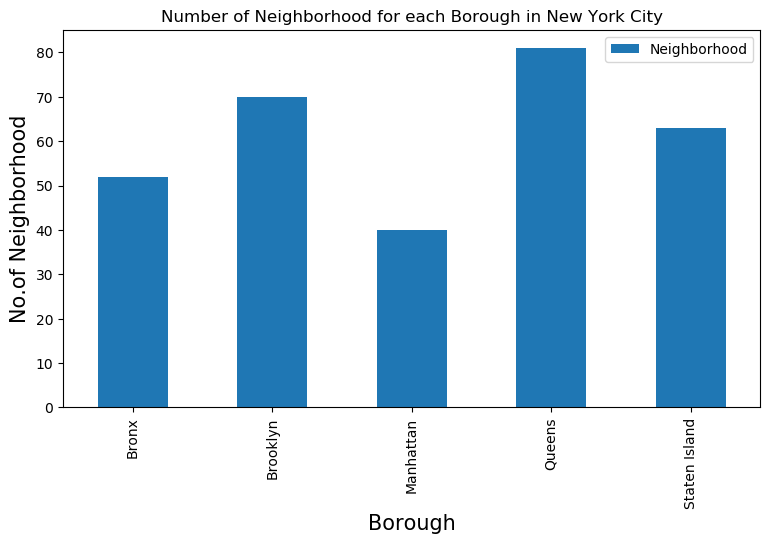

In [10]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

As we can see, Queens has highest number of neighborhoods

Now we will collect Halal resturants for each Neighborhood

In [13]:
# prepare neighborhood list that contains Halal resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Halal_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Halal_resturants=venues[venues['Category']=='Halal Restaurant']   
    print('(',count,'/',len(new_york_data),')','Halal Resturants in '+Neighborhood+', '+Borough+':'+str(len(Halal_resturants)))
    for resturant_detail in Halal_resturants.values.tolist():
        id, name , category=resturant_detail
        Halal_rest_ny = Halal_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Halal Resturants in Wakefield, Bronx:0
( 2 / 306 ) Halal Resturants in Co-op City, Bronx:0
( 3 / 306 ) Halal Resturants in Eastchester, Bronx:0
( 4 / 306 ) Halal Resturants in Fieldston, Bronx:0
( 5 / 306 ) Halal Resturants in Riverdale, Bronx:0
( 6 / 306 ) Halal Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Halal Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Halal Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Halal Resturants in Norwood, Bronx:0
( 10 / 306 ) Halal Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Halal Resturants in Baychester, Bronx:0
( 12 / 306 ) Halal Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Halal Resturants in City Island, Bronx:0
( 14 / 306 ) Halal Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Halal Resturants in University Heights, Bronx:0
( 16 / 306 ) Halal Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Halal Resturants in Fordham, Bronx:0
( 18 / 306 ) Halal Resturants in East Tremont, Bronx:0
( 19 / 306 ) Halal Resturants in W

( 146 / 306 ) Halal Resturants in Rego Park, Queens:0
( 147 / 306 ) Halal Resturants in Woodhaven, Queens:0
( 148 / 306 ) Halal Resturants in Ozone Park, Queens:0
( 149 / 306 ) Halal Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Halal Resturants in College Point, Queens:0
( 151 / 306 ) Halal Resturants in Whitestone, Queens:0
( 152 / 306 ) Halal Resturants in Bayside, Queens:0
( 153 / 306 ) Halal Resturants in Auburndale, Queens:0
( 154 / 306 ) Halal Resturants in Little Neck, Queens:0
( 155 / 306 ) Halal Resturants in Douglaston, Queens:0
( 156 / 306 ) Halal Resturants in Glen Oaks, Queens:0
( 157 / 306 ) Halal Resturants in Bellerose, Queens:1
( 158 / 306 ) Halal Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) Halal Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Halal Resturants in Briarwood, Queens:0
( 161 / 306 ) Halal Resturants in Jamaica Center, Queens:2
( 162 / 306 ) Halal Resturants in Oakland Gardens, Queens:0
( 163 / 306 ) Halal Resturants in Queens Vil

( 285 / 306 ) Halal Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Halal Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Halal Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Halal Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Halal Resturants in Roxbury, Queens:0
( 290 / 306 ) Halal Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Halal Resturants in Middle Village, Queens:0
( 292 / 306 ) Halal Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Halal Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Halal Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Halal Resturants in Malba, Queens:0
( 296 / 306 ) Halal Resturants in Highland Park, Brooklyn:0
( 297 / 306 ) Halal Resturants in Madison, Brooklyn:0
( 298 / 306 ) Halal Resturants in Bronxdale, Bronx:0
( 299 / 306 ) Halal Resturants in Allerton, Bronx:0
( 300 / 306 ) Halal Resturants in Kingsbridge Heights, Bronx:0
( 301 / 306 ) Halal Resturants in Erasmus, Brook

Now that we have got all the Halal resturants in new york city , we will analyze it

In [14]:
Halal_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Bay Ridge,55a88497498ee3c7364c0d21,Istanbul Kitchen
1,Brooklyn,Manhattan Terrace,562828f2498ea6b65c7a257c,Affy's Premium Grill
2,Brooklyn,Flatbush,5b5fd2872632ec002c907cda,Jalsa - Grill And Gravy
3,Brooklyn,Dyker Heights,55a88497498ee3c7364c0d21,Istanbul Kitchen
4,Brooklyn,Ocean Parkway,562828f2498ea6b65c7a257c,Affy's Premium Grill


In [15]:
Halal_rest_ny.shape

(18, 4)

We got 18 Halal Resturants across New York City

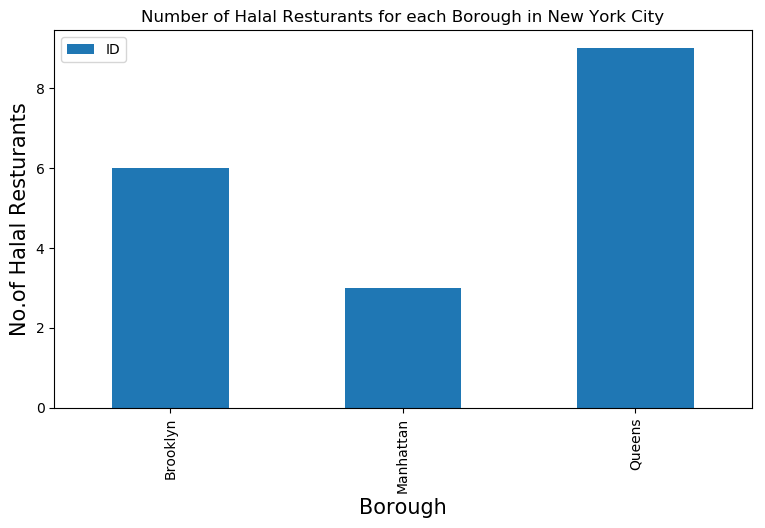

In [16]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Halal Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Halal Resturants', fontsize=15)
#giving a bar plot
Halal_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Brooklyn has the largest number of Halal resturants

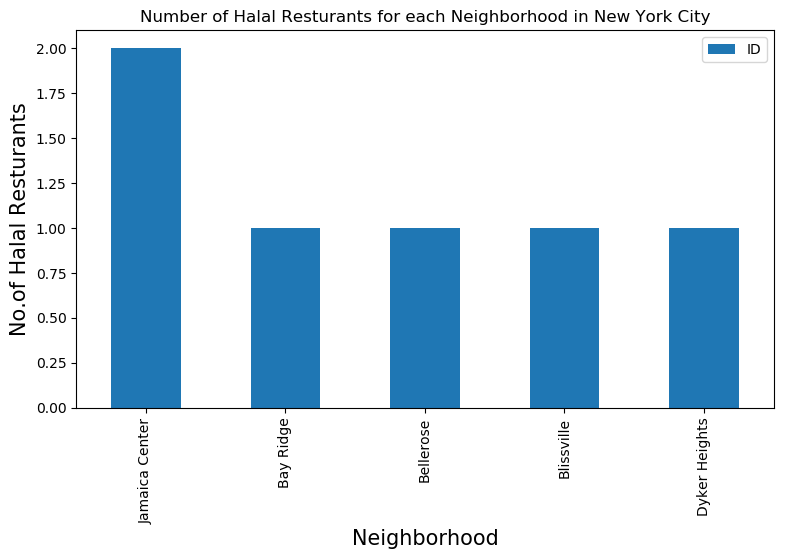

In [17]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Halal Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Halal Resturants', fontsize=15)
#giving a bar plot
Halal_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


Now we will get the ranking of each resturant for further analysis.

In [18]:
# prepare neighborhood list that contains Halal resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Halal_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in Halal_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Halal_rest_ny),')','processed')
    Halal_rest_stats_ny =Halal_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID              Name  Likes  Rating  Tips
0  55a88497498ee3c7364c0d21  Istanbul Kitchen      8     7.7     3
( 1 / 18 ) processed
                         ID                  Name  Likes  Rating  Tips
0  562828f2498ea6b65c7a257c  Affy's Premium Grill     12     7.8     5
( 2 / 18 ) processed
                         ID                     Name  Likes  Rating  Tips
0  5b5fd2872632ec002c907cda  Jalsa - Grill And Gravy      7     7.5     4
( 3 / 18 ) processed
                         ID              Name  Likes  Rating  Tips
0  55a88497498ee3c7364c0d21  Istanbul Kitchen      8     7.7     3
( 4 / 18 ) processed
                         ID                  Name  Likes  Rating  Tips
0  562828f2498ea6b65c7a257c  Affy's Premium Grill     12     7.8     5
( 5 / 18 ) processed
                         ID              Name  Likes  Rating  Tips
0  55a88497498ee3c7364c0d21  Istanbul Kitchen      8     7.7     3
( 6 / 18 ) processed
                         ID            N

In [19]:
Halal_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,55a88497498ee3c7364c0d21,Istanbul Kitchen,8,7.7,3
1,Brooklyn,Manhattan Terrace,562828f2498ea6b65c7a257c,Affy's Premium Grill,12,7.8,5
2,Brooklyn,Flatbush,5b5fd2872632ec002c907cda,Jalsa - Grill And Gravy,7,7.5,4
3,Brooklyn,Dyker Heights,55a88497498ee3c7364c0d21,Istanbul Kitchen,8,7.7,3
4,Brooklyn,Ocean Parkway,562828f2498ea6b65c7a257c,Affy's Premium Grill,12,7.8,5


In [20]:
Halal_rest_stats_ny.shape

(18, 7)

In [21]:
Halal_rest_ny.shape

(18, 4)

So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required


In [22]:
Halal_rest_stats_ny.to_csv('Halal_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [23]:
Halal_rest_stats_ny_csv=pd.read_csv('Halal_rest_stats_ny.csv')

In [24]:
Halal_rest_stats_ny_csv.shape

(18, 7)

In [25]:
Halal_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,55a88497498ee3c7364c0d21,Istanbul Kitchen,8,7.7,3
1,Brooklyn,Manhattan Terrace,562828f2498ea6b65c7a257c,Affy's Premium Grill,12,7.8,5
2,Brooklyn,Flatbush,5b5fd2872632ec002c907cda,Jalsa - Grill And Gravy,7,7.5,4
3,Brooklyn,Dyker Heights,55a88497498ee3c7364c0d21,Istanbul Kitchen,8,7.7,3
4,Brooklyn,Ocean Parkway,562828f2498ea6b65c7a257c,Affy's Premium Grill,12,7.8,5


In [26]:
Halal_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
Borough         18 non-null object
Neighborhood    18 non-null object
ID              18 non-null object
Name            18 non-null object
Likes           18 non-null object
Rating          18 non-null float64
Tips            18 non-null object
dtypes: float64(1), object(6)
memory usage: 1.1+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis


In [27]:
Halal_rest_stats_ny['Likes']=Halal_rest_stats_ny['Likes'].astype('float64')

In [28]:
Halal_rest_stats_ny['Tips']=Halal_rest_stats_ny['Tips'].astype('float64')

In [29]:
Halal_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
Borough         18 non-null object
Neighborhood    18 non-null object
ID              18 non-null object
Name            18 non-null object
Likes           18 non-null float64
Rating          18 non-null float64
Tips            18 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.1+ KB


Now the data types looks correct

In [30]:
# Resturant with maximum Likes
Halal_rest_stats_ny.iloc[Halal_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              523cc0df11d2ba091e493432
Name                      The Halal Guys
Likes                                691
Rating                               8.5
Tips                                 134
Name: 7, dtype: object

In [31]:
# Resturant with maximum Rating
Halal_rest_stats_ny.iloc[Halal_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              523cc0df11d2ba091e493432
Name                      The Halal Guys
Likes                                691
Rating                               8.5
Tips                                 134
Name: 7, dtype: object

In [32]:
# Resturant with maximum Tips
Halal_rest_stats_ny.iloc[Halal_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              523cc0df11d2ba091e493432
Name                      The Halal Guys
Likes                                691
Rating                               8.5
Tips                                 134
Name: 7, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [33]:
ny_neighborhood_stats=Halal_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [34]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
7,Gramercy,8.5
14,Stuyvesant Town,8.5
11,Manhattan Valley,7.9
12,Ocean Parkway,7.8
10,Manhattan Terrace,7.8
0,Bay Ridge,7.7
3,Dyker Heights,7.7
6,Fort Hamilton,7.7
4,Flatbush,7.5
9,Jamaica Hills,7.3


Above are the top neighborhoods with top average rating of Halal resturants

In [35]:
ny_borough_stats=Halal_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [36]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.300000
0,Brooklyn,7.700000
2,Queens,3.088889


Similarly these are the average rating of Halal Resturants for each Borough  

Lets visualize it

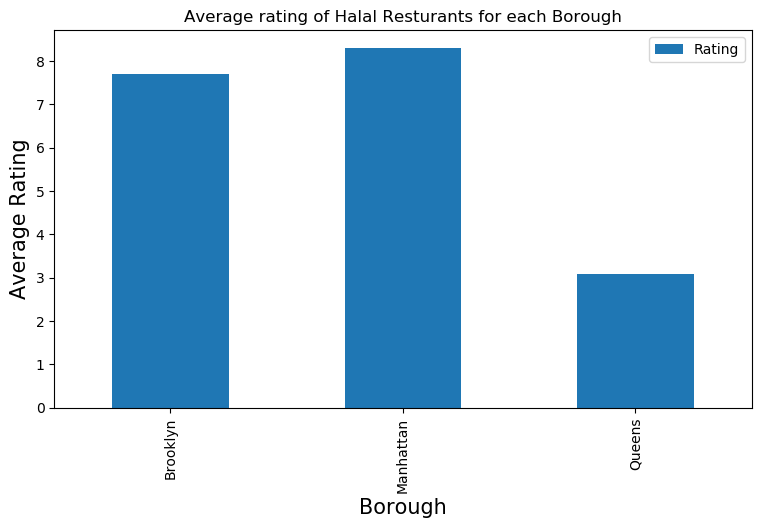

In [37]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Halal Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
Halal_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 7.0 to visualize on map

In [38]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]

In [39]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bay Ridge,7.7
3,Dyker Heights,7.7
4,Flatbush,7.5
6,Fort Hamilton,7.7
7,Gramercy,8.5
9,Jamaica Hills,7.3
10,Manhattan Terrace,7.8
11,Manhattan Valley,7.9
12,Ocean Parkway,7.8
14,Stuyvesant Town,8.5


We will join this dataset to original new york data to get lonitude and latitude


In [40]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [41]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [42]:

ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bay Ridge,40.625801,-74.030621,7.7
1,Brooklyn,Dyker Heights,40.619219,-74.019314,7.7
2,Brooklyn,Flatbush,40.636326,-73.958401,7.5
3,Brooklyn,Fort Hamilton,40.614768,-74.031979,7.7
4,Manhattan,Gramercy,40.737210,-73.981376,8.5
5,Queens,Jamaica Hills,40.711460,-73.796465,7.3
6,Brooklyn,Manhattan Terrace,40.614433,-73.957438,7.8
7,Manhattan,Manhattan Valley,40.797307,-73.964286,7.9
8,Brooklyn,Ocean Parkway,40.613060,-73.968367,7.8
9,Manhattan,Stuyvesant Town,40.731000,-73.974052,8.5


Now we will show this data on a map

In [43]:

# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [44]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [45]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [56]:
#add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
Lets Visualize Boroughs based on average Rating

In [55]:

ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
#Borough Boundaries.geojson=https://data.beta.nyc/dataset/68c0332f-c3bb-4a78-a0c1-32af515892d6/resource/7c164faa-4458-4ff2-9ef0-09db00b509ef/download/42c737fd496f4d6683bba25fb0e86e1dnycboroughboundaries.geojson
ny_geo = r'https://data.beta.nyc/dataset/68c0332f-c3bb-4a78-a0c1-32af515892d6/resource/7c164faa-4458-4ff2-9ef0-09db00b509ef/download/42c737fd496f4d6683bba25fb0e86e1dnycboroughboundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.borough',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')


### Conclusion
* Gramercy (Manhattan), Stuyvesant Town(Manhattan), Manhattan Valley(Manhattan Valley) are some of the best neighborhoods for Halal cuisine.
* Manhattan have potential Halal Restaurant Market.
* Queens ranks last in average rating of Halal Restaurants.
* Manhattan is the best place to stay if you prefer Halal Cuisine.   

### Limitations
* The ranking is purely on basis of rating of restaurants
* The accuracy of data depends purely depends on the data provided by FourSquare